### First, let's add more features to see if that will improve.

In [1]:
from sklearn import datasets
import numpy as np

In [2]:
iris = datasets.load_iris()
#X = iris["data"][:,3:]  # petal width
X = iris["data"][:,:]
y = (iris["target"]==2).astype(np.int)
X.shape, y.shape

((150, 4), (150,))

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
X_train.shape, X_val.shape, X_test.shape

((108, 4), (27, 4), (15, 4))

In [4]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [5]:
def binary_loss(X, Y, weights, alpha=0.00001):
    """
    X.shape = (num_instances, num_features)
    Y.shape = (num_instances,)
    weights.shape = (num_features,)
    """
    z = np.dot(X, weights)
    h = sigmoid(z)
    total_cost = (-Y*np.log(h) - (1-Y)*np.log(1-h)).mean() + alpha * np.sum(np.dot(weights, weights.T))
    return total_cost

In [6]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

def SGD(X_tr, Y_tr, X_dev=[], Y_dev=[], lr=0.1, alpha=0.00001, epochs=5, tolerance=0.0001, print_progress=True):
    train_loss_history, val_loss_history = [], []
    num_features = X_tr.shape[1]
    #weights = np.zeros(shape=(num_features,), dtype=np.float64)
    weights = np.random.randn(num_features)
    clip_value = 1e-9
    #X_tr = np.clip(X_tr, clip_value, 1-clip_value)
    mms = MinMaxScaler()
    #mms = StandardScaler()
    X_tr = mms.fit_transform(X_tr)
    for epoch in range(epochs):
        indices = np.arange(X_tr.shape[0])
        np.random.shuffle(indices)
        X_tr = X_tr[indices]
        Y_tr = Y_tr[indices]

        # training loop
        train_loss = 0
        for idx, row in enumerate(X_tr):
            row = np.reshape(row, (1, num_features))
            train_loss += binary_loss(row, Y_tr[idx], weights, alpha)
            for i in range(len(row)):
                gradient = (sigmoid(row @ weights) - float(Y_tr[idx])) * row[0, i] + alpha*weights[i]
                weights[i] = weights[i] - lr*gradient
        train_loss /= X_tr.shape[0]
        train_loss_history.append(train_loss)

        if len(X_dev) != 0 and len(Y_dev) != 0:
            X_dev = mms.transform(X_dev)
            val_loss = binary_loss(X_dev, Y_dev, weights, alpha)
            val_loss_history.append(val_loss)

            if print_progress:
                print(f"Epoch: {epoch+1}")
                print(f"Training loss:   {train_loss:.4f}")
                print(f"Validation loss: {val_loss:.4f}")

            # Wang seems to want the training process to stop when the progress becomes no longer significant.
            if epoch >=1:
                if np.abs(val_loss_history[epoch]-val_loss_history[epoch-1]) < tolerance:
                    break

    return weights, train_loss_history, val_loss_history

In [7]:
n_epochs = 100
w, train_hist, val_hist = SGD(X_train, y_train, X_dev=X_val, Y_dev=y_val, epochs=n_epochs, print_progress=False)

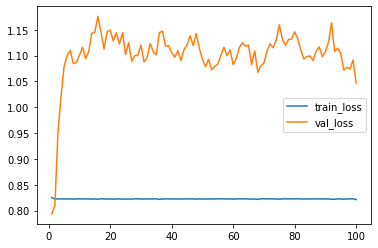

In [8]:
import matplotlib.pyplot as plt
x = range(1, len(train_hist)+1)
plt.plot(x, train_hist, label="train_loss")
plt.plot(x, val_hist, label="val_loss")
plt.legend();

In [9]:
#prediction = 

### Let's try to train with `LogisticRegression`

In [10]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

LogisticRegression()

In [11]:
from sklearn.metrics import confusion_matrix

In [12]:
y_val_pred = log_reg.predict(X_val)
confusion_matrix(y_val, y_val_pred)

array([[17,  0],
       [ 0, 10]])

In [13]:
y_test_pred = log_reg.predict(X_test)
confusion_matrix(y_test, y_test_pred)

array([[12,  0],
       [ 0,  3]])

### Bias term
Maybe the problem was that we do not manually add a bias term?

In [14]:
X_train.shape

(108, 4)

In [15]:
X_t = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_t.shape

(108, 5)

In [16]:
X_v = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_v.shape

(27, 5)

In [17]:
n_epochs = 100
w, train_hist, val_hist = SGD(X_t, y_train, X_dev=X_v, Y_dev=y_val, epochs=n_epochs, print_progress=False)

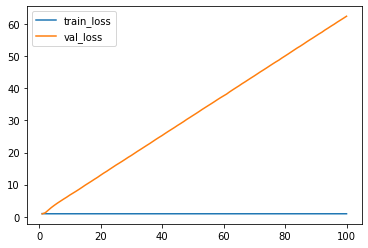

In [20]:
import matplotlib.pyplot as plt
x = range(1, len(train_hist)+1)
plt.plot(x, train_hist, label="train_loss")
plt.plot(x, val_hist, label="val_loss")
plt.legend();

No, this is not where the problem lies.

### The most suspectible being the function `SGD()`
Let's look closer into this function.

### No `clip()`

- It is weird to `clip()` the training data values unless we are really sure about the range of our data values
  - I don't know the originally NLP dataset, but `clip()` is not suitable for Iris dataset here.

In [21]:
np.clip(-7, 0, 10), np.clip(38, 0, 10)

(0, 10)

In [22]:
X_train[:10, :]

array([[6.7, 2.5, 5.8, 1.8],
       [5.7, 2.8, 4.1, 1.3],
       [5.5, 2.5, 4. , 1.3],
       [5.2, 2.7, 3.9, 1.4],
       [6. , 2.2, 5. , 1.5],
       [7.6, 3. , 6.6, 2.1],
       [6.3, 3.3, 4.7, 1.6],
       [5.5, 2.4, 3.8, 1.1],
       [5.5, 4.2, 1.4, 0.2],
       [5.2, 4.1, 1.5, 0.1]])

Problems in the function `SGD()`:
- The training loss is no longer quite accurate, albeit acceptable. In particular, it is unfair to compare `val_loss` with `train_loss`; only looking the history exclusively within each one makes sense.
- $\frac{\partial L}{\partial w_i} = (h-y)x_i + 2\alpha w_i\quad$ if $\quad L = -y\log h - (1-y)\log (1-h) + \alpha \lVert w \rVert^2$

In [26]:
row = np.arange(1*3).reshape((1,3))
weights = np.random.randn(3)
row, weights

(array([[0, 1, 2]]), array([ 0.42646796, -0.41958437,  0.99195053]))

In [27]:
row @ weights

array([1.5643167])

In [28]:
np.dot(row, weights)

array([1.5643167])

In [62]:
def SGD(X_tr, Y_tr, X_dev=[], Y_dev=[], lr=0.1, alpha=0.00001, epochs=5, tolerance=0.0001, print_progress=True):
    train_loss_history, val_loss_history = [], []
    num_features = X_tr.shape[1]
    #weights = np.zeros(shape=(num_features,), dtype=np.float64)
    weights = np.random.randn(num_features)
    #clip_value = 1e-9
    #X_tr = np.clip(X_tr, clip_value, 1-clip_value)
    mms = MinMaxScaler()
    #mms = StandardScaler()
    X_tr = mms.fit_transform(X_tr)
    for epoch in range(epochs):
        indices = np.arange(X_tr.shape[0])
        np.random.shuffle(indices)
        X_tr = X_tr[indices]
        Y_tr = Y_tr[indices]

        # training loop
        train_loss = 0
        for idx, row in enumerate(X_tr):
            row = np.reshape(row, (1, num_features))
            train_loss += binary_loss(row, Y_tr[idx], weights, alpha)
            for i in range(len(row)):
                gradient = (sigmoid(row @ weights) - float(Y_tr[idx])) * row[0, i] + alpha*weights[i]*2
                weights[i] -= lr*gradient
        train_loss /= X_tr.shape[0]
        train_loss_history.append(train_loss)

        if len(X_dev) != 0 and len(Y_dev) != 0:
            X_dev = mms.transform(X_dev)
            val_loss = binary_loss(X_dev, Y_dev, weights, alpha)
            val_loss_history.append(val_loss)

            if print_progress:
                print(f"Epoch: {epoch+1}")
                print(f"Training loss:   {train_loss:.4f}")
                print(f"Validation loss: {val_loss:.4f}")

            # Wang seems to want the training process to stop when the progress becomes no longer significant.
            if epoch >=1:
                if np.abs(val_loss_history[epoch]-val_loss_history[epoch-1]) < tolerance:
                    break

    return weights, train_loss_history, val_loss_history

In [63]:
w, train_hist, val_hist = SGD(X_train, y_train, X_dev=X_val, Y_dev=y_val, epochs=n_epochs, print_progress=False)

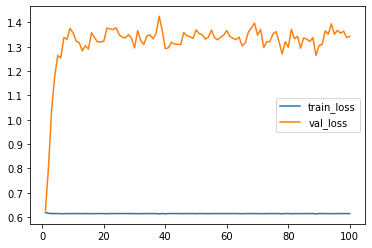

In [64]:
x = range(1, len(train_hist)+1)
plt.plot(x, train_hist, label="train_loss")
plt.plot(x, val_hist, label="val_loss")
plt.legend();

In [68]:
y_val_pred = (sigmoid(X_val @ w) > 0.5).astype(np.int)
y_val_pred

array([1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1,
       0, 0, 1, 1, 1])

In [69]:
confusion_matrix(y_val, y_val_pred)

array([[ 8,  9],
       [ 0, 10]])

In [70]:
y_test_pred = (sigmoid(X_test @ w) > 0.5).astype(np.int)
y_test_pred

array([1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0])

In [71]:
confusion_matrix(y_test, y_test_pred)

array([[7, 5],
       [0, 3]])

In [58]:
n_epochs = 100
#w, train_hist, val_hist = SGD(X_t, y_train, X_dev=X_v, Y_dev=y_val, epochs=n_epochs, print_progress=False)
#w, train_hist, val_hist = SGD(X_t, y_train, X_dev=X_v, Y_dev=y_val, epochs=n_epochs, print_progress=False, lr=0.04)
w, train_hist, val_hist = SGD(X_t, y_train, X_dev=X_v, Y_dev=y_val, epochs=n_epochs, print_progress=False, alpha=0)

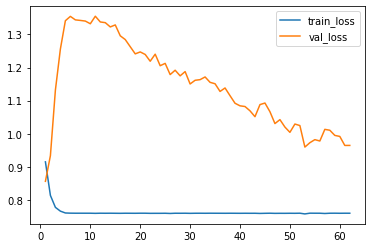

In [59]:
x = range(1, len(train_hist)+1)
plt.plot(x, train_hist, label="train_loss")
plt.plot(x, val_hist, label="val_loss")
plt.legend();

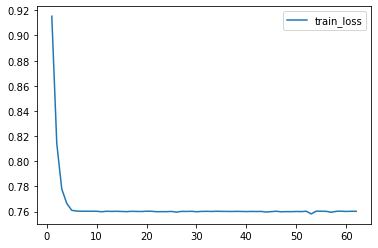

In [60]:
x = range(1, len(train_hist)+1)
plt.plot(x, train_hist, label="train_loss")
plt.legend();

### Curious. I cannot seem to spot the bug.
Let's try with [`sklearn.linear_model.SGDClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)

In [48]:
from sklearn.linear_model import SGDClassifier

In [50]:
clf = SGDClassifier(loss="log")
clf.fit(X_train, y_train)

SGDClassifier(loss='log')

In [51]:
y_test_pred = clf.predict(X_test)
confusion_matrix(y_test, y_test_pred)

array([[12,  0],
       [ 2,  1]])

In [52]:
y_val_pred = clf.predict(X_val)
confusion_matrix(y_val, y_val_pred)

array([[17,  0],
       [ 5,  5]])